# Zwei Kenngrößen für den Niederschlagsexpositionsindex

## 1) Regenspende $RN(60\,\text{min}, T=10\,\text{a})$
**Definition:** Bemessungsintensität eines Starkregens für die Dauerstufe 60 Minuten und eine Wiederkehrzeit von 10 Jahren. Einheit **l/(s·ha)**.  
**Interpretation:** Wie stark ein einstündiges Ereignis im Mittel „pro Fläche“ fällt. Steht für pluviale Gefährdung in Siedlungsgebieten, typische Überlastung von Entwässerungssystemen, Straßenabfluss, Kellerüberflutung.  
(Sie beschreibt die Menge an Regenwasser, die in einem bestimmten Zeitraum auf einer bestimmten Oberfläche anfällt und wird üblicherweise in Litern pro Sekunde und Hektar (l/(s·ha)) angegeben)

**Nutzung im Index:** Das RN-Raster wird auf Gemeindeebene aggregiert (alle berührten Rasterzellen einbeziehen, Mittelwert oder Q90), anschließend in **robuste z-Werte** überführt.  
**Begründung:** Kurzzeitige, konvektive Ereignisse sind für Wohnimmobilien in Städten besonders relevant.

## 2) Niederschlagshöhe $HN(24\,\text{h}, T=20\,\text{a})$
**Definition:** Bemessungsniederschlag über 24 Stunden mit einer Wiederkehrzeit von 20 Jahren. Einheit **mm**.  
**Interpretation:** Kumulierte Menge eines langandauernden Ereignisses. Spiegelt flächenhafte Belastungen wider, z. B. Bodensättigung, Hangwasser, Flurabfluss, überörtliche Stauungen.  
**Nutzung im Index:** Das HN-Raster wird analog gemeindeweise aggregiert und in **robuste z-Werte** transformiert.  
**Begründung:** Langanhaltender Regen wirkt über Sättigung und großräumige Abflüsse auf Gebäude, auch außerhalb dichter Innenstädte.

## Kombination zum Teilindex „Starkregen“
$$
S_{\text{Starkregen}} \;=\; 0{,}6 \cdot z \big(RN_{60,T10}\big) \;+\; 0{,}4 \cdot z\big(HN_{24h,T20}\big)
$$
Optional lässt sich $S_{\text{Starkregen}}$ für die Kommunikation auf **0–100** skalieren.

**Gesamtbegründung:** RN erfasst die kurzzeitige, städtisch geprägte Pluvialgefahr (Überflutungsgefahr). HN ergänzt um die langdauernde, flächenhafte Belastung. Die Kombination bildet ein robustes, leicht berechenbares Expositionsmaß für Wohnimmobilien.


In [2]:
import pandas as pd
import geopandas as gpd

import choropleth_pipeline as cp

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LogNorm, TwoSlopeNorm

In [32]:
# Pfade anpassen:
VG250_GPKG = "../geometry/DE_VG250.gpkg"   
RN60_T10_ASC = "../data/DWDgrid/KOSTRA/Rn_KOSTRA-DWD-2020_D00060_T010.asc"
HN24_T20_ASC = "../data/DWDgrid/KOSTRA/Hn_KOSTRA-DWD-2020_D01440_T020.asc"  # 24h = 1440 min

from choropleth_pipeline import (
    SourceSpec, VG250Spec, process_sources,
    robust_z, scale_0_100
)  # nutzt :contentReference[oaicite:2]{index=2}

# verwaltungsflächen laden
vg = VG250Spec(gpkg_path=VG250_GPKG, id_col="ARS")

# KOSTRA liegt in ETRS89-LAEA → EPSG:3035
srcs = [
    SourceSpec(name="RN60_T10", path=RN60_T10_ASC, fallback_crs="EPSG:3035"),
    SourceSpec(name="HN24_T20", path=HN24_T20_ASC, fallback_crs="EPSG:3035"),
]

# Gemeindebezogene Aggregation; schnell & robust: Mittelwert
# (Optional: stats=("mean","percentile_90"))
gdf = process_sources(
    sources=srcs,
    vg=vg,
    target_level="GEM",
    stats=("mean",),
    all_touched=True
)  # gibt AGS, geometry, RN60_T10_mean, HN24_T20_mean zurück :contentReference[oaicite:3]{index=3}

# z-Scores je Kennzahl
gdf["RN60_z"] = robust_z(gdf["RN60_T10_mean"])
gdf["HN24_z"] = robust_z(gdf["HN24_T20_mean"])

# kombinierter Starkregen-Subindex (Gewichte nach Bedarf anpassen, zum Beispiel mit fl_suv gewichten)
gdf["S_starkregen"] = 0.6*gdf["RN60_z"] + 0.4*gdf["HN24_z"]

# 0–100-Skalierung für Darstellung/Index
gdf["S_starkregen_0_100"] = scale_0_100(gdf["S_starkregen"])

gdf["RN60_0_100"] = scale_0_100(gdf['RN60_z'])
gdf["HN24_0_100"] = scale_0_100(gdf['HN24_z'])

# # Abspeichern für spätere Karten/Joins
# out_gpkg = "exports/starkregen_gemeinden.gpkg"
# gdf.to_file(out_gpkg, layer="starkregen_gem", driver="GPKG")
# print("Gespeichert:", out_gpkg)


In [33]:
vg = VG250Spec(gpkg_path=VG250_GPKG, id_col="ARS")

laender = cp.load_level(vg, 'LAN')

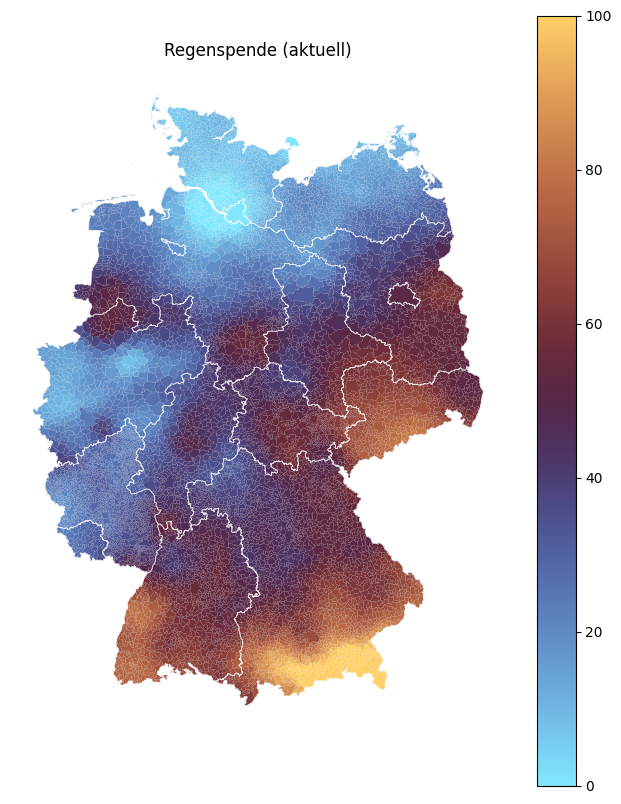

In [34]:
value_col = "RN60_0_100"

fig, ax = cp.plot_choropleth_continuous(
    gdf,
    value_col,
    cmap_name="managua_r",          
    title=f"Regenspende (aktuell)",
    laender = laender,
    figsize=(8, 10),
    norm = TwoSlopeNorm(vmin=0, vcenter=50, vmax=100) 
)

# Speichern
out_file = cp.save_map(
    fig, 
    filename=f"RN60_scaled.png", 
    out_dir="exports",
    dpi=300
)

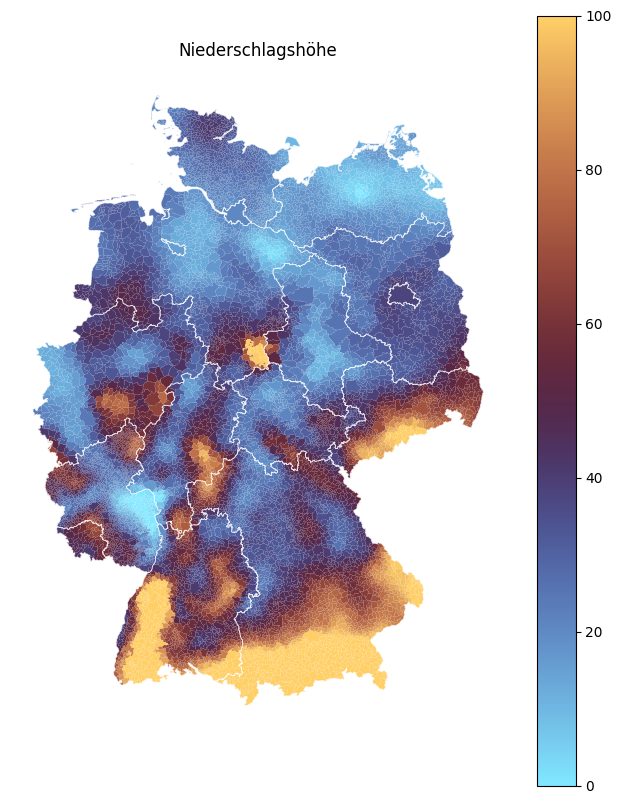

In [35]:
value_col = "HN24_0_100"

fig, ax = cp.plot_choropleth_continuous(
    gdf,
    value_col,
    cmap_name="managua_r",          
    title=f"Niederschlagshöhe",
    laender = laender,
    figsize=(8, 10),
    norm = TwoSlopeNorm(vmin=0, vcenter=50, vmax=100) 
)

# Speichern
out_file = cp.save_map(
    fig, 
    filename=f"HN24_scaled.png", 
    out_dir="exports",
    dpi=300
)

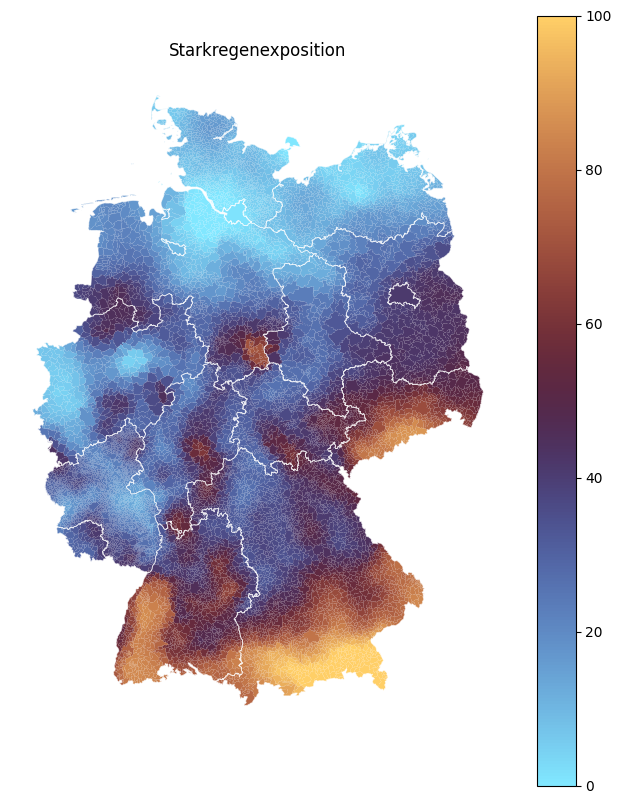

In [36]:
value_col = "S_starkregen_0_100"

fig, ax = cp.plot_choropleth_continuous(
    gdf,
    value_col,
    cmap_name="managua_r",          
    title=f"Starkregenexposition",
    laender = laender,
    figsize=(8, 10),
    norm = TwoSlopeNorm(vmin=0, vcenter=50, vmax=100) 
)

# Speichern
out_file = cp.save_map(
    fig, 
    filename=f"Starkregen_scaled.png", 
    out_dir="exports",
    dpi=300
)

### Statisk

In [37]:
gdf.columns

Index(['ARS', 'geometry', 'RN60_T10_mean', 'HN24_T20_mean', 'RN60_z', 'HN24_z',
       'S_starkregen', 'S_starkregen_0_100', 'RN60_0_100', 'HN24_0_100'],
      dtype='object')

In [28]:
# Redundanz von H35 berechnen nach Spearman
rho = gdf['HN24_z'].corr(gdf['RN60_z'], method = "spearman")

# >0.8: H35 weitgehend redundant
rho

np.float64(0.6472753777208424)

### Final Export

In [38]:
# cols = ['ARS', 'RN60_T10_mean', 'HN24_T20_mean', 'RN60_z', 'HN24_z',
#        'S_starkregen', 'S_starkregen_0_100', 'RN60_0_100', 'HN24_0_100']

# df = gdf[cols].copy()
# df.to_csv('csv/Starkregenindex.csv', index = False)

### Starkregenindex unter Beachtung des Siedlungs- und Verkehrsflächen Anteils

Das ist nur eine Seitenbetrachtung. In VUL ist der Siedlungs- und Verkehrsflächenanteil enthalten, und erzeugt diesen Term später.

In [18]:
# starkregenindex
si = pd.read_csv('csv/Starkregenindex.csv', dtype= {'ARS':str})

# flaechennutzungsanteile (22)
flaechen = pd.read_csv(
    'csv/U65_kreise.csv',
    usecols = ['KRS1222','Kreisname','fl_suv'],
    dtype={'KRS1222':'string'}
)

# pfad für geometrie
VG250_GPKG = "../geometry/DE_VG250.gpkg"

# Geometriedaten
vg = cp.VG250Spec(gpkg_path=VG250_GPKG, id_col="ARS")

# layer laden
gemeinden = cp.load_level(vg, 'GEM')
kreise = cp.load_level(vg, 'KRS')
laender = cp.load_level(vg, 'LAN')

# Für Kreise sind die drei letzten Stellen null!
kreise['AGS8'] = kreise['ARS'].str[:5]+"000"
gemeinden['AGS8'] = gemeinden['ARS'].str[:5]+"000"

# um gemeindedaten anzufügen, nutze die ersten fünf stellen von ARS
gemeinden['ARS5'] = gemeinden['ARS'].str[:5]
si['ARS5']     = si['ARS'].str[:5]

# gemeinden ist ein gdf, wir hängen nur daten an
gdf = gemeinden.merge(
    si,
    on = 'ARS',
    how = 'inner'
).merge(
    flaechen,
    left_on = 'AGS8',
    right_on = 'KRS1222',
    how = 'inner'
)

In [19]:
gdf.shape

(10957, 40)

In [20]:
gdf.head(5)

,OBJID,BEGINN,ADE,GF,BSG,ARS,AGS,SDV_ARS,GEN,BEZ,...,RN60_z,HN24_z,S_starkregen,S_starkregen_0_100,RN60_0_100,HN24_0_100,ARS5_y,KRS1222,Kreisname,fl_suv
0,DEBKGVG200000008,2022-12-20,6,4,1,010010000000,01001000,010010000000,Flensburg,Stadt,...,-1.359523,0.133335,-0.762379,14.979351,8.947307,39.205131,01001,01001000,Flensburg,53.50
1,DEBKGVG200000009,2022-12-20,6,4,1,010020000000,01002000,010020000000,Kiel,Stadt,...,-1.454171,-0.394149,-1.030162,8.697297,6.860190,28.018485,01002,01002000,Kiel,58.78
2,DEBKGVG20000000A,2024-04-04,6,4,1,010030000000,01003000,010030000000,Lübeck,Stadt,...,-1.249618,-0.862283,-1.094684,7.183654,11.370857,18.090522,01003,01003000,Lübeck,37.86
3,DEBKGVG20000000B,2022-12-20,6,4,1,010040000000,01004000,010040000000,Neumünster,Stadt,...,-1.545084,-0.489427,-1.122821,6.523572,4.855447,25.997885,01004,01004000,Neumünster,51.81
4,DEBKGVG20000000C,2023-10-04,6,4,1,010510011011,01051011,010510011011,Brunsbüttel,Stadt,...,-1.604553,-0.806264,-1.285238,2.713351,3.544061,19.278543,01051,01051000,Dithmarschen,11.28


In [23]:
# SI*SUV
gdf['HE'] = gdf['S_starkregen']*gdf['fl_suv']
gdf['HE_0_100'] = cp.scale_0_100(gdf['HE'],1,99)

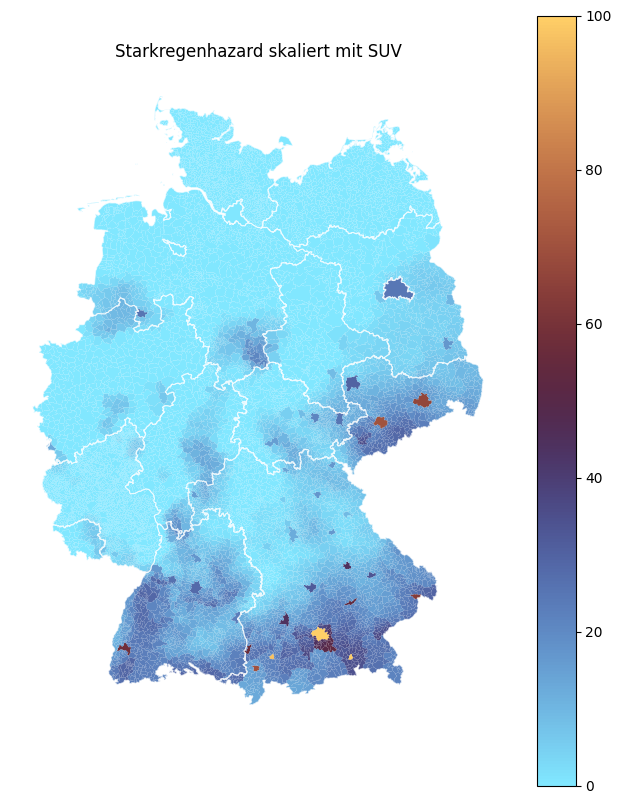

In [24]:
value_col = "HE"

fig, ax = cp.plot_choropleth_continuous(
    gdf,
    value_col,
    cmap_name="managua_r",          
    title=f"Starkregenhazard skaliert mit SUV",
    laender = laender,
    figsize=(8, 10),
    norm = TwoSlopeNorm(vmin=0, vcenter=50, vmax=100) 
)

# Speichern
# out_file = cp.save_map(
#     fig, 
#     filename=f"Starkregen_scaled.png", 
#     out_dir="exports",
#     dpi=300
# )